In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Spotify Audio Features

In [6]:
df_spot = pd.read_csv('../data/df_emo_top_long_nm_spfy.csv')

In [19]:
df_spot.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,img_link
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0.603201,5.413997,-9.960021,0.117143,0.276626,0.39402,0.205935,0.453084,114.752799,https://media.pitchfork.com/photos/601c69fcfdb...
1,1,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0.603201,5.413997,-9.960021,0.117143,0.276626,0.39402,0.205935,0.453084,114.752799,https://media.pitchfork.com/photos/601c69fcfdb...


**avg scores per topic model**

In [7]:
from sklearn.preprocessing import MinMaxScaler

def spotfeats(data,alb):
    df_spot2 = pd.DataFrame()
    df_spot2 = data.loc[data['album'] == alb] # ) & (data['topic']==topics)]    
    #df_spot2 = data.loc[data['subgenre'] == alb] # ) & (data['topic']==topics)]    
    #df_spot3 = df_spot2.loc[df_spot2['year']<=2018]
    df_spot2 = df_spot2[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','loudness']]
    
    # get mean of scores
    df_spot2 = df_spot2[['acousticness',   'instrumentalness', 'tempo', 'speechiness', 'valence','energy','liveness','danceability','loudness']].mean()    
    df_spot3 = pd.DataFrame(df_spot2)
    df_spot3_T = df_spot3.T
    df_spot3_T['loudness'] = abs(df_spot3_T['loudness'])
       
    
    return df_spot3_T

### Search baesd - 3 matches on Radiohead

In [20]:
df_spot_kkoala=spotfeats(df_spot,'Music to Draw to: Satellite')

In [21]:
df_spot_kkoala.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.768278,0.722217,95.963556,0.042,0.138256,0.174753,0.103917,0.247494,19.473056


**Radar function**

In [1075]:
import base64
from io import StringIO

# import matplotlib.pyplot as plt
# import streamlit as st
# from matplotlib import numpy as np

# def render_svg(svg_file):

#     with open(svg_file, "r") as f:
#         lines = f.readlines()
#         svg = "".join(lines)

#         """Renders the given svg string."""
#         b64 = base64.b64encode(svg.encode("utf-8")).decode("utf-8")
#         html = r'<img src="data:image/svg+xml;base64,%s"/>' % b64
#         return html

In [12]:
import math

In [49]:
%matplotlib inline

def radar(data,gen,colors):

    # convert column names into a list
    categories=list(data.columns)
    # number of categories
    N=len(categories)

    # create a list with the average of all features
    value = list(data.mean())
    
    # tempo - scaled
    value[2] = value[2]/220
    
    # speech - scaled
    value[3] = value[3]*1.2
    
    # inst - scaled
    value[1] = value[1] # *2
    
    # loudness - scaled
    value[8] = value[8]/25
    
    # repeat first value to close the circle
    # the plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    value+=value[:1]
    
    # calculate angle for each category
    angles=[n/float(N)*2*math.pi for n in range(N)]
    angles+=angles[:1]

    # plot
    fig=plt.figure(figsize = (10,10))

    ax = fig.add_subplot(221, polar=True)

    #plot 1 hits
    ax.plot(angles, value,  linewidth=2, label = gen, color= colors)
    ax.fill(angles, value, alpha=0.35, facecolor=colors)
    ax.set_ylim(0, 1)
    
    ax.grid(True)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),fontsize='large')

    plt.xticks(angles[:-1],categories, size=12,color='black')
    plt.yticks(color='grey',size=12)

    # Create a color palette:
    plt.cm.get_cmap("Set2", len(data.index))
    plt.savefig(f'../img/radar_{gen}.png',transparent=True)
    #plt.savefig(f'../img/radar_{gen}.svg',transparent=True)
    #plt.savefig(f'../img/radar_{gen}.png',transparent=True)
    plt.show()

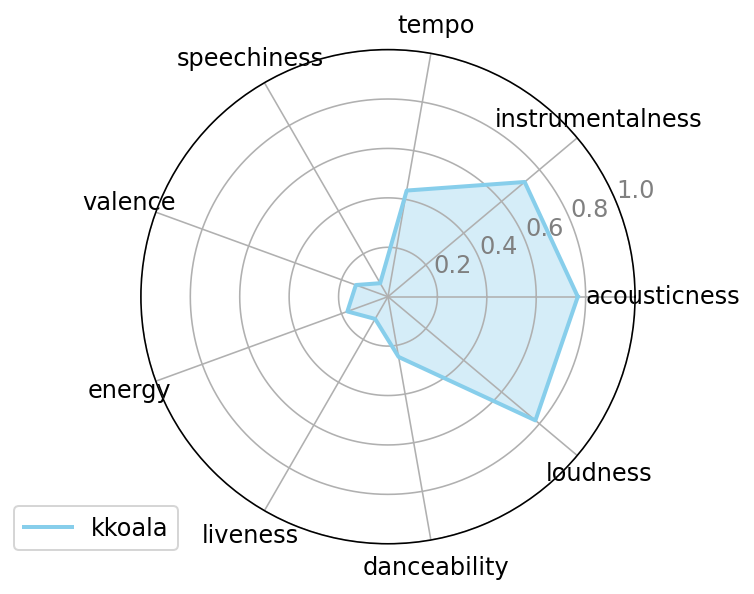

In [23]:
radar(df_spot_kkoala,'kkoala','skyblue')

In [26]:
df_spot_rglasp=spotfeats(df_spot,'ArtScience')

In [27]:
df_spot_rglasp.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.115265,0.100392,118.758667,0.06115,0.36775,0.579583,0.161242,0.613667,8.17175


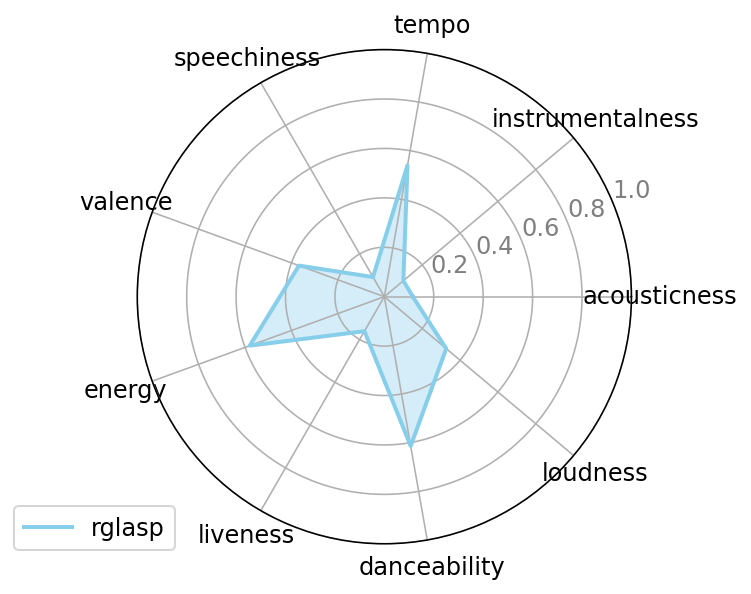

In [28]:
radar(df_spot_rglasp,'rglasp','skyblue')

In [31]:
df_spot_rglasp2=spotfeats(df_spot,'Covered')

In [32]:
df_spot_rglasp2.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.40376,0.000031,124.9348,0.0302,0.15354,0.424,0.09236,0.3884,9.285


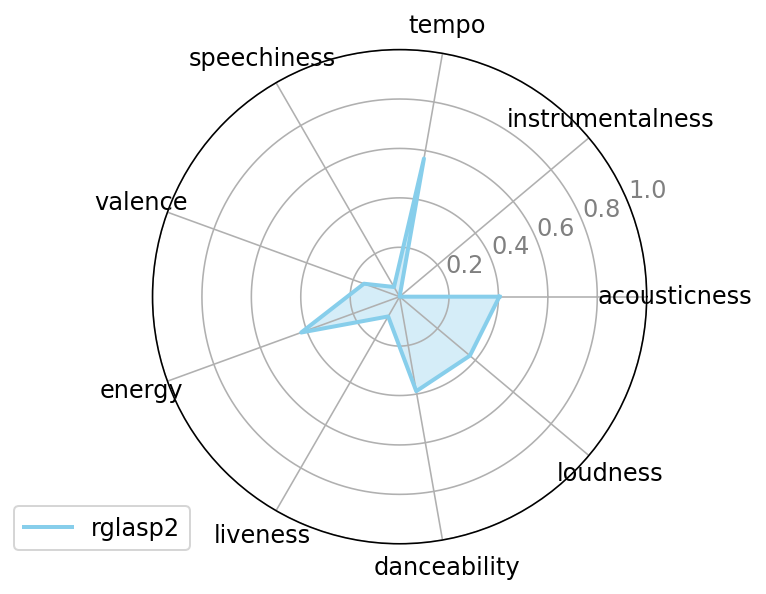

In [33]:
radar(df_spot_rglasp2,'rglasp2','skyblue')

### by Genre (electronic , dark ambient , belong)

In [34]:
df_spot_belong1=spotfeats(df_spot,'Common Era')

In [36]:
df_spot_belong1.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.45308,0.829,114.076222,0.048722,0.265089,0.651778,0.172978,0.183989,8.897889


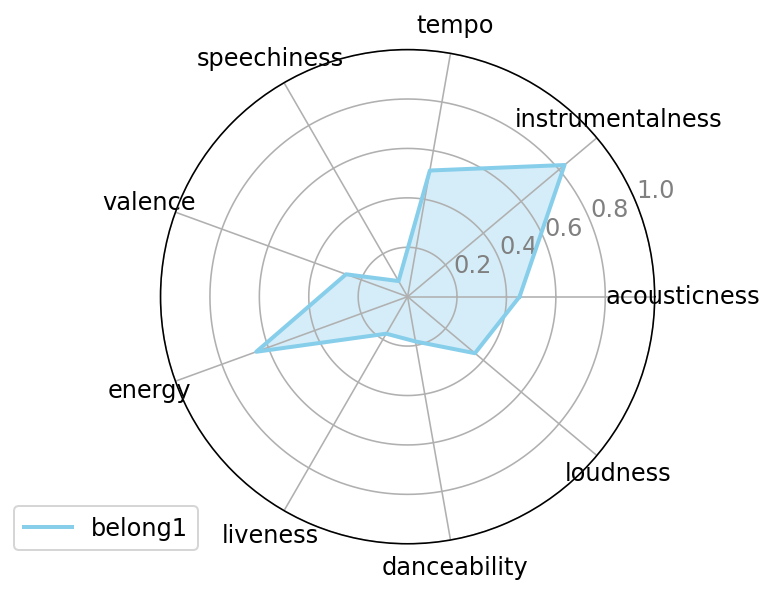

In [37]:
radar(df_spot_belong1,'belong1','skyblue')

In [40]:
df_spot_belong2=spotfeats(df_spot,'Colorloss Record EP')

In [41]:
df_spot_belong2.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.9335,0.93875,75.268,0.051975,0.176,0.4705,0.10195,0.11525,20.95975


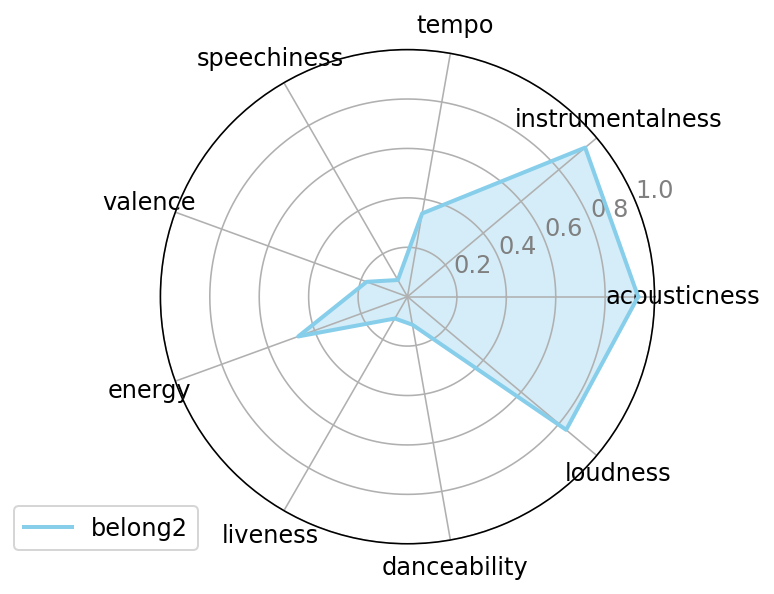

In [42]:
radar(df_spot_belong2,'belong2','skyblue')

In [43]:
df_spot_belong3=spotfeats(df_spot,'October Language')

In [44]:
df_spot_belong3.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.60225,0.810341,85.629375,0.054512,0.120175,0.269437,0.099413,0.169425,12.01825


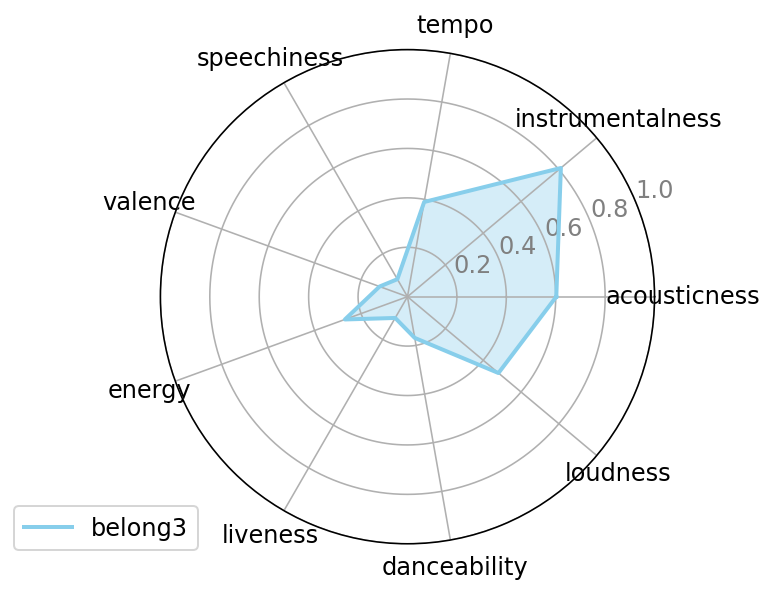

In [45]:
radar(df_spot_belong3,'belong3','skyblue')

In [46]:
df_spot_alog=spotfeats(df_spot,'Unemployed')

In [47]:
df_spot_alog.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.0366,0.000002,153.84,0.724,0.139,0.375,0.111,0.875,6.669


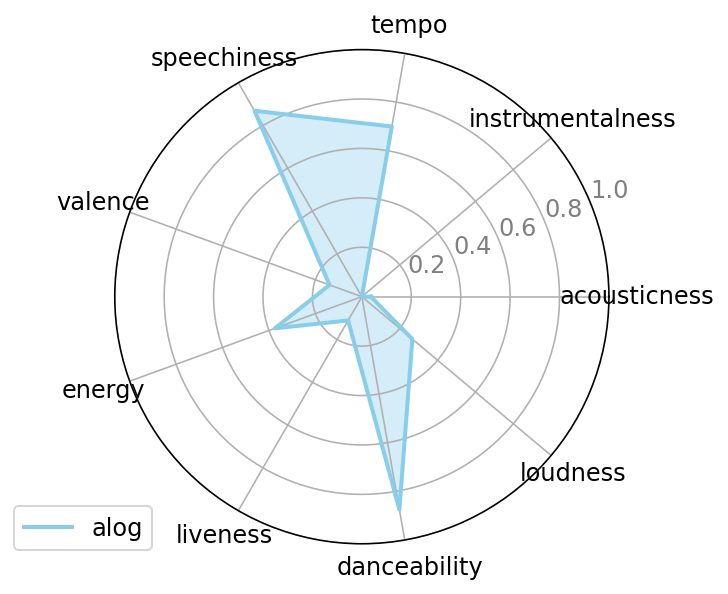

In [50]:
radar(df_spot_alog,'alog','skyblue')

In [51]:
df_spot_jaga=spotfeats(df_spot,'One-Armed Bandit')

In [52]:
df_spot_jaga.head(10)

,acousticness,instrumentalness,tempo,speechiness,valence,energy,liveness,danceability,loudness
0,0.133005,0.723889,124.427333,0.072011,0.460678,0.745778,0.190067,0.443333,9.060111


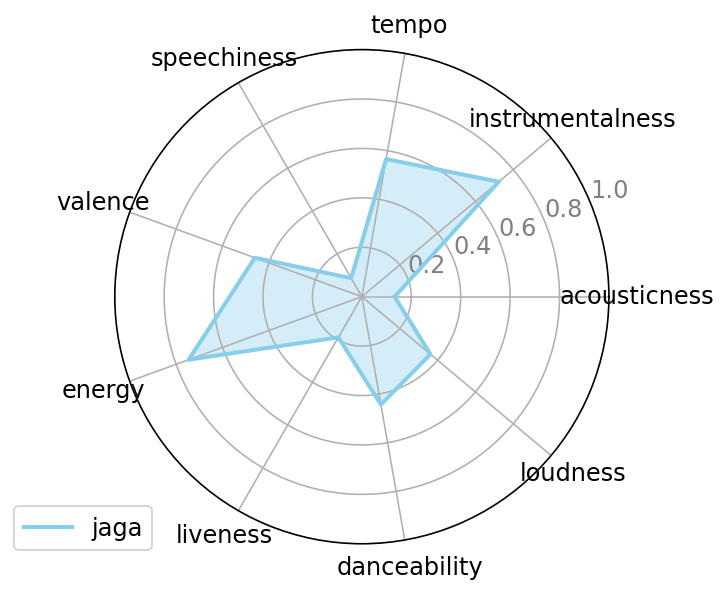

In [53]:
radar(df_spot_jaga,'jaga','skyblue')